In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)


Using device: cuda
Using downloaded and verified file: ./data\MNIST\raw\train-images-idx3-ubyte.gz
Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Using downloaded and verified file: ./data\MNIST\raw\train-labels-idx1-ubyte.gz
Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Using downloaded and verified file: ./data\MNIST\raw\t10k-images-idx3-ubyte.gz
Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 4543412.54it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [3]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = nn.functional.interpolate(decoded, size=(56, 56), mode='bilinear', align_corners=False)
        return decoded

In [4]:
autoencoder = Autoencoder().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [5]:
num_epochs = 10
for epoch in range(num_epochs):
    for images, _ in train_loader:

        images = images.to(device)

        noise_factor = 0.5
        noisy_images = images + noise_factor * torch.randn(images.shape, device=device)
        noisy_images = torch.clamp(noisy_images, 0.0, 1.0)

        downsampled_images = nn.functional.interpolate(noisy_images, scale_factor=0.5, mode='bilinear', align_corners=False)
        upsampled_images = nn.functional.interpolate(downsampled_images, size=(56, 56), mode='bilinear', align_corners=False)

        outputs = autoencoder(upsampled_images)
        loss = criterion(outputs, upsampled_images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}")

Epoch [1/10], Loss: 0.00018641
Epoch [2/10], Loss: 0.00007792
Epoch [3/10], Loss: 0.00004774
Epoch [4/10], Loss: 0.00003689
Epoch [5/10], Loss: 0.00002790
Epoch [6/10], Loss: 0.00003095
Epoch [7/10], Loss: 0.00002100
Epoch [8/10], Loss: 0.00001875
Epoch [9/10], Loss: 0.00001689
Epoch [10/10], Loss: 0.00001523


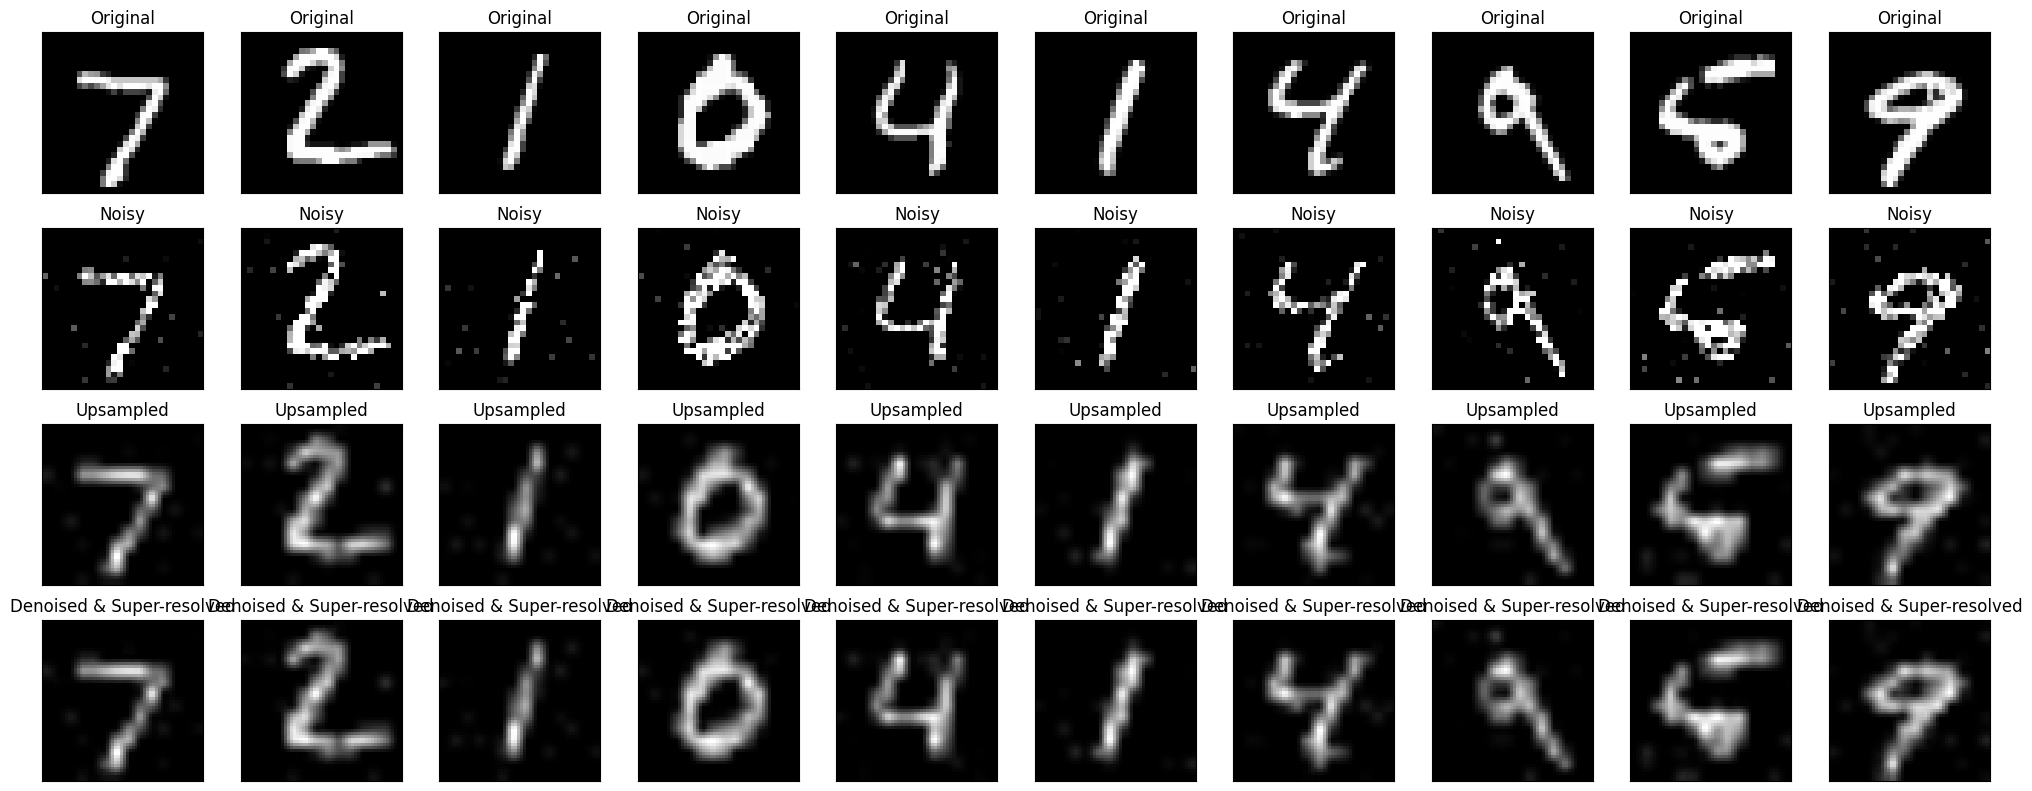

In [6]:
autoencoder.eval()
with torch.no_grad():
    for images, _ in test_loader:

        images = images.to(device)

        noise_factor = 0.5
        noisy_images = images + noise_factor * torch.randn(images.shape, device=device)
        noisy_images = torch.clamp(noisy_images, 0.0, 1.0)

        downsampled_images = nn.functional.interpolate(noisy_images, scale_factor=0.5, mode='bilinear', align_corners=False)
        upsampled_images = nn.functional.interpolate(downsampled_images, size=(56, 56), mode='bilinear', align_corners=False)

        denoised_images = autoencoder(upsampled_images)

        images = images.cpu()
        noisy_images = noisy_images.cpu()
        upsampled_images = upsampled_images.cpu()
        denoised_images = denoised_images.cpu()

        n = 10
        plt.figure(figsize=(20, 8))
        for i in range(n):

            ax = plt.subplot(4, n, i + 1)
            plt.imshow(images[i].squeeze().numpy(), cmap='gray', interpolation='nearest')
            ax.set_title("Original")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            ax = plt.subplot(4, n, i + 1 + n)
            plt.imshow(noisy_images[i].squeeze().numpy(), cmap='gray', interpolation='nearest')
            ax.set_title("Noisy")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)


            ax = plt.subplot(4, n, i + 1 + 2 * n)
            plt.imshow(upsampled_images[i].squeeze().numpy(), cmap='gray', interpolation='nearest')
            ax.set_title("Upsampled")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            ax = plt.subplot(4, n, i + 1 + 3 * n)
            plt.imshow(denoised_images[i].squeeze().numpy(), cmap='gray', interpolation='nearest')
            ax.set_title("Denoised & Super-resolved")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        plt.tight_layout()
        plt.show()
        break